# Time Series analysis of **Cisco Webex Cpu Usage, Memory Consumption & Disk Utilisation**

In [19]:
import keras
import random
import warnings
import datetime
import itertools
import numpy as np
import pandas as pd
import statsmodels.api as sm
from itertools import product
import matplotlib.pyplot as plt
from chart_studio.plotly import plot_mpl
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from plotly.offline import init_notebook_mode, iplot
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
warnings.filterwarnings('ignore')
    
def preprocessData(clusterName):
    df=pd.read_csv('automation/'+clusterName+'.csv')
    df['date'] = 0
    for i in range(len(df.timestamps)):
        df['date'][i] = datetime.datetime.fromtimestamp(df.timestamps[i]/1000.0).strftime('%Y-%m-%d')
    df = df.drop(columns = ['timestamps', 'Unnamed: 0'])
    df['date']=pd.to_datetime(df['date'])
    df.set_index('date',inplace=True)
    return df

def plotSeries(df, metrics=['cpu'], days = 153, normalized = False):
    plt.figure(figsize = (25, 6))
    colors = ['blue', 'green', 'red']
    for i, metric in enumerate(metrics):
        if normalized:
            plt.plot(df.index[:days], df[metric][:days]/(max(df[metric])), color = colors[i], label = metric)
            plt.xlabel('Date', fontsize = 20)
            if len(metrics) == 1:
                plt.ylabel(metric, fontsize = 20)
                plt.title(metric+" on daily basis", fontsize = 20)
        else:
            plt.plot(df.index[:days], df[metric][:days], color = colors[i], label = metric)
            plt.xlabel('Date', fontsize = 20)
            if len(metrics) == 1:
                plt.ylabel(metric, fontsize = 20)
                plt.title(metric+" on daily basis", fontsize = 20)
    plt.legend(fontsize = 15)
    plt.show()

def extractingFeature(df, metric=['cpu'], days = 153, trainSize = 0.8):
    training_data_length = int(days*trainSize)
    feature = pd.DataFrame(df[metric])
    X_train = feature[:training_data_length]
    X_test = feature[training_data_length:days]
    return feature, X_train, X_test

def plotData(data, label, metrics=['cpu']):
    colors = ['blue', 'green', 'red', 'magenta', 'black', 'cyan', 'yellow']
    random.shuffle(colors)
    plt.figure(figsize = (25, 8))
    for i in range(len(label)):
        plt.plot(data[i][metrics[i]], color = colors[i], label = label[i])
        plt.xlabel('Date', fontsize = 20)
        plt.ylabel(label[i], fontsize = 20)
        plt.title(label[i], fontsize=20)
    plt.legend(fontsize = 15)
    plt.show()


def adfuller_test(df, metric='cpu'):
    result=adfuller(df[metric].dropna())
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("Weak evidence against null hypothesis, time series has a unit root, indicating it is Non-Stationary ")

def seasonal_decompose_analysis(timeseries, model = 'additive'):
    decomposition = seasonal_decompose(timeseries, model = model)

    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    plt.figure(figsize=(20, 15))
    plt.subplot(411)
    plt.title('Original', fontsize=20)
    plt.plot(timeseries, label='Original')
    plt.subplot(412)
    plt.title('Trend', fontsize=20)
    plt.plot(trend, label='Trend')
    plt.subplot(413)
    plt.title('Seasonality', fontsize=20)
    plt.plot(seasonal,label='Seasonality')
    plt.subplot(414)
    plt.title('Residuals', fontsize=20)
    plt.plot(residual, label='Residuals')
    plt.tight_layout()
    plt.show()
    return decomposition
        
def differencing(X_train, X_test, metric = 'cpu'):
    X_train[metric+'_first_difference'] = X_train[metric] - X_train[metric].shift(1)
    X_test[metric+'_first_difference'] = X_test[metric] - X_test[metric].shift(1)
    return X_train, X_test


def plotCurves(df, metric='cpu'):
    plt.figure(figsize=(20,6))
    autocorrelation_plot(df[metric])
    plt.show()
    
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    fig = plot_acf(df[metric],lags=40,ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = plot_pacf(df[metric],lags=40,ax=ax2)
    plt.show()

    
def sarima(df, order, metric='cpu', seasonalOrder = (0,0,0,0)):
    model = sm.tsa.statespace.SARIMAX(X_train['cpu'],order=order, seasonal_order = seasonalOrder)
    modelFit = model.fit()
    return modelFit
   
def arima(df, order, metric='cpu'):
    model = ARIMA(df[metric], order = order)
    modelFit = model.fit()
    return modelFit
    

def predict(df, modelFit, start = 123, end = 152):
    df['forecast'] = modelFit.predict(start = start, end = end)
    return df

def autoArima(df, startp, maxp, startq, maxq, startP, maxP, startQ, maxQ, seasonal, d, D, metric = 'cpu', m=12):
    for i in range(1, m):
        model = auto_arima(df[metric], start_p=startp, start_q=startq, max_p=maxp, max_q=maxq, m=i, start_P=startP, seasonal=seasonal, d=d, D=D,
                       trace=True, error_action='ignore', suppress_warnings=True, stepwise=True, n_jobs=-1)
        print(model.aic())
        print('\n')

        
def error(df, metric='cpu'):
    return mean_absolute_error(df[metric][1:], df['forecast'][1:])


def optimizeSARIMA(df, parameters_list, d, D, s, metric='cpu'):
    results = []
    best_aic = float('inf')
    print('Parameters list of length '+str(len(parameters_list))+' to be processed\n')
    for param in parameters_list:
        try: 
            if s:
                model = sm.tsa.statespace.SARIMAX(df[metric], order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
            else:
                model = sm.tsa.statespace.SARIMAX(df[metric], order=(param[0], d, param[1])).fit(disp=-1)
            
        except:
            continue
            
        aic = model.aic
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
        print(str(param)+' has been processed having AIC: '+str(aic)+'\n')

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)    
    return result_table


def gridSearch(df, maxp, maxq, s, metric='cpu'):
    ps = range(0, maxp)
    d = 1
    qs = range(0, maxq)
    D = 0
    if s:
        Ps = range(0, maxp)
        Qs = range(0, maxq)
        s = s
        D = 1
        parameters = product(ps, qs, Ps, Qs)
    else:
        parameters = product(ps, qs)
    
    parameters_list = list(parameters)
    result_table = optimizeSARIMA(df, parameters_list, d, D, s, metric='cpu')
    if s:
        p, q, P, Q = result_table.parameters[0]
        bestModel = sm.tsa.statespace.SARIMAX(df[metric], order=(p, d, q), seasonal_order=(P, D, Q, s)).fit(disp=-1)
    else:
        p, q = result_table.parameters[0]
        bestModel = sm.tsa.statespace.SARIMAX(df[metric], order=(p, d, q)).fit(disp=-1)
    
    print(bestModel.summary())
    return bestModel

def timeSeriesAnalysis(clusterName, metric, maxp, maxq, s, days=153, trainSize=0.8, start=123, end=152):
    df = preprocessData(clusterName)    
    _, X_train, X_test = extractingFeature(df, metric, days=days, trainSize=trainSize)
    bestModelFit = gridSearch(X_train, maxp, maxq, s)
    X_test = predict(X_test, bestModelFit, start, end)
    errorInPrediction = error(X_test)
    plotData([X_train, X_test, X_test], label = ['trainingData', 'testData', 'forecast'], metrics = ['cpu', 'cpu', 'forecast'])
    

Parameters list of length 81 to be processed

(0, 0, 0, 0) has been processed having AIC: 1328.507840893271

(0, 0, 0, 1) has been processed having AIC: 1276.689674199514

(0, 0, 0, 2) has been processed having AIC: 1278.6827518016407

(0, 0, 1, 0) has been processed having AIC: 1302.4426917997182

(0, 0, 1, 1) has been processed having AIC: 1278.6797833226647

(0, 0, 1, 2) has been processed having AIC: 1278.001673995103

(0, 0, 2, 0) has been processed having AIC: 1290.4181988750768

(0, 0, 2, 1) has been processed having AIC: 1279.984952936936

(0, 0, 2, 2) has been processed having AIC: 1279.4238809090903

(0, 1, 0, 0) has been processed having AIC: 1328.6570460802507

(0, 1, 0, 1) has been processed having AIC: 1277.3362365130893

(0, 1, 0, 2) has been processed having AIC: 1279.32244822634

(0, 1, 1, 0) has been processed having AIC: 1302.5130448593338

(0, 1, 1, 1) has been processed having AIC: 1279.324718075788

(0, 1, 1, 2) has been processed having AIC: 1278.6493592255474

(

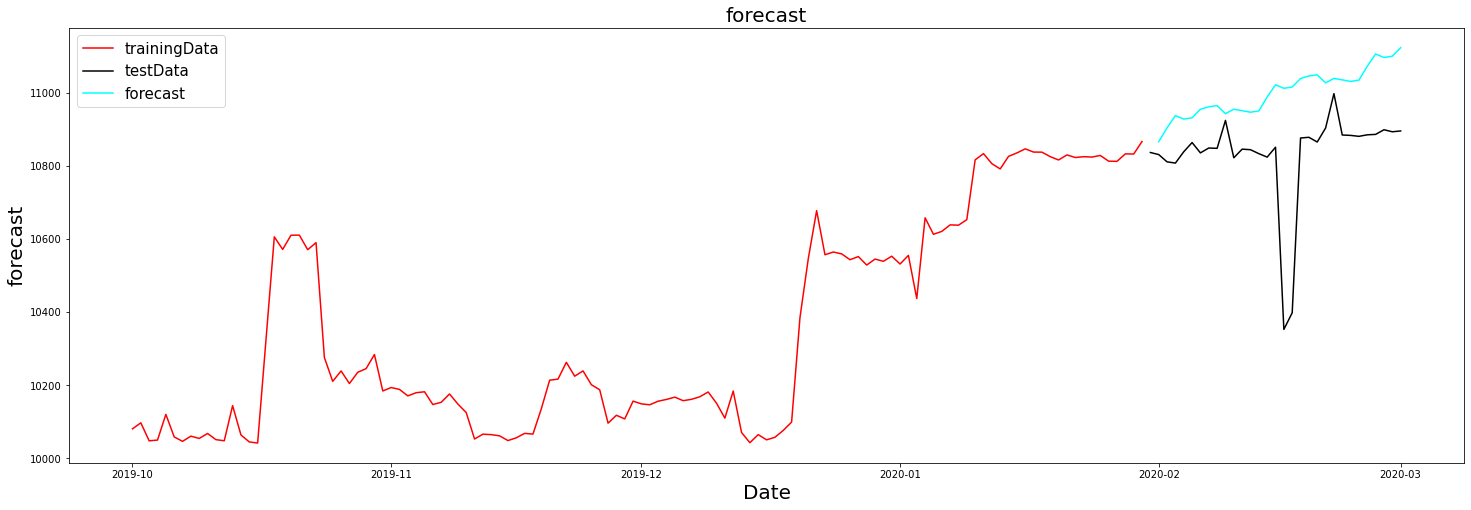

Wall time: 5min 43s


In [23]:
%%time
timeSeriesAnalysis('AMS01-TVPP1-CloudCenter-Cluster', 'cpu', 3, 3, 12)

In [ ]:
# plotSeries(df, metrics = ['cpu', 'mem', 'disk'], normalized=True)
# plotData([X_train, X_test], label = ['trainingData', 'testData'], metrics = ['cpu', 'cpu'])
# plotData([X_train[1:]], label = ['cpu_first_difference'], metrics = ['cpu_first_difference'])
# plotCurves(X_train, metric='cpu')

# print(adfuller_test(X_train))
# X_train, X_test = differencing(X_train, X_test)
# print(X_train.head())
# print(adfuller_test(X_train, metric='cpu_first_difference'))